# Twitter US Airlines Sentiment

## Contents

- Overview
- Load data
- Explore of data
- Format data for language model training
- Train language model
- Evaluate language model
- Format data for classifier
- Train classifier
- Evaluate
- Conclusions

## Overview

I am practicing my AI and data science skills in various projects.
While working on the Food-101 dataset, I had a lot of success using the fastai approach from lesson 1 of their online course Practical Deep Learning for Coders, v3 (https://course.fast.ai/videos/?lesson=1): https://github.com/ruthschulz/data_science_playground/blob/master/food_101-resnet50-fastai.ipynb

In lesson 4 of their online course Practical Deep Learning for Coders, v3 (https://course.fast.ai/videos/?lesson=4) they use ULMFiT (https://arxiv.org/pdf/1801.06146.pdf) to train a language model and classify IMDb reviews as positive or negative.

In this notebook I use ULMFiT to train a language model and classify tweets about US Airlines as positive, neutral, or negative. The dataset is from Kaggle (originally from Crowdflower).

First I explore the dataset with some visualisations.
Next I train a language model on the tweets.
Finally I train a classifier on the tweets. 

The language model predicts the next word with an accuracy of 28.77%.

The classifier predicts the sentiment of tweets with an accuracy of 83.81%.

Note that for simplicity in this notebook I have only separated the dataset out into training and validation sets, so do not report a test set accuracy.

### Kaggle: Twitter US Airline dataset

https://www.kaggle.com/crowdflower/twitter-airline-sentiment

The data we're providing on Kaggle is a slightly reformatted version of the original source. It includes both a CSV file and SQLite database. The code that does these transformations is available on GitHub

For example, it contains whether the sentiment of the tweets in this set was positive, neutral, or negative for six US airlines


The following kaggle kernel reached an accuracy of 81.35% using a Random Forest Classifier:
https://www.kaggle.com/jiashenliu/how-can-we-predict-the-sentiment-by-tweets

The following kaggle kernel uses the same ULMFiT model and reaches a validation accuracy of 81.6% and a test accuracy of 77.8%:
https://www.kaggle.com/wesleyliao3/sentiment-analysis-using-rnn-lstm-ulmfit

### Crowdflower: Airline Twitter sentiment

https://www.figure-eight.com/data-for-everyone/

A sentiment analysis job about the problems of each major U.S. airline. Twitter data was scraped from February of 2015 and contributors were asked to first classify positive, negative, and neutral tweets, followed by categorizing negative reasons (such as “late flight” or “rude service”).

Added: February 12, 2015 by CrowdFlower | Data Rows: 16000

### Fellowship.ai Challenge

I came across this dataset while looking at data science fellowships, one of which being Fellowship.ai. (https://fellowship.ai/) As part of their application process they have several challenges to complete, including one using this Twitter US Airlines Sentiment.

https://fellowship.ai/challenge

ULMFiT Sentiment

Apply a supervised or semi-supervised ULMFiT model to Twitter US Airlines Sentiment 

## Loading data

I initially loaded the data from kaggle, but kept it in my google drive to speed things up and save downloading it every time.

Using kaggle with colab:
https://towardsdatascience.com/setting-up-kaggle-in-google-colab-ebb281b61463


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [0]:
%reload_ext autoreload
%autoreload 2

In [0]:
from fastai.text import *

In [0]:
import os
if not os.path.exists("./gdrive"):
  from google.colab import drive
  drive.mount('/content/gdrive')

In [0]:
import shutil

In [0]:
import os

In [0]:
df = pd.read_csv('./gdrive/My Drive/Colab Notebooks/data/Tweets.csv')

## Explore data

The dataset includes 14640 tweets about 6 US Airlines (Virgin America, United, Southwest, Delta, US Airways, and American) made between 16 February 2015 and 24 February 2015.

Each tweet has been classified as positive, neutral, or negative.

There is a sentiment confidence column that indicates the proportion of people classifying the tweets who agreed on the classification for that tweet.

For negative tweets, the people classifying tweets also determined the reason for the negative tweet as one of 9 reasons or "Can't tell".

There are a lot more negative tweets than either positive or neutral tweets.

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
tweet_id                        14640 non-null int64
airline_sentiment               14640 non-null object
airline_sentiment_confidence    14640 non-null float64
negativereason                  9178 non-null object
negativereason_confidence       10522 non-null float64
airline                         14640 non-null object
airline_sentiment_gold          40 non-null object
name                            14640 non-null object
negativereason_gold             32 non-null object
retweet_count                   14640 non-null int64
text                            14640 non-null object
tweet_coord                     1019 non-null object
tweet_created                   14640 non-null object
tweet_location                  9907 non-null object
user_timezone                   9820 non-null object
dtypes: float64(2), int64(2), object(11)
memory usage: 1.7+ MB


In [9]:
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


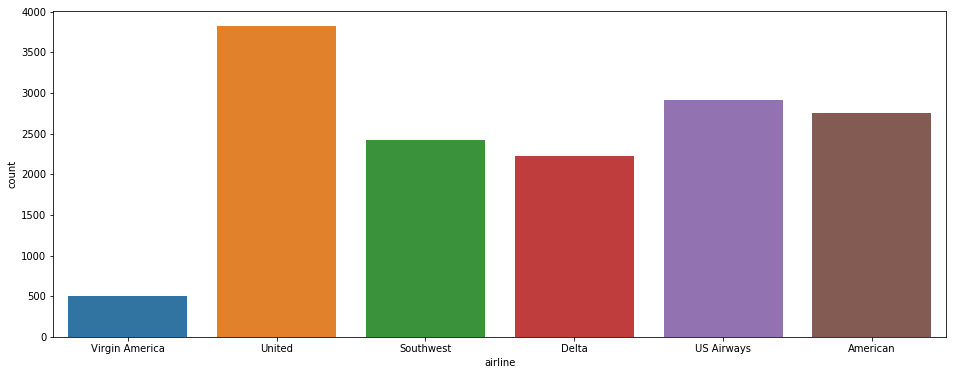

In [10]:
plt.figure(figsize=(16,6))
sns.countplot(x='airline', data=df)

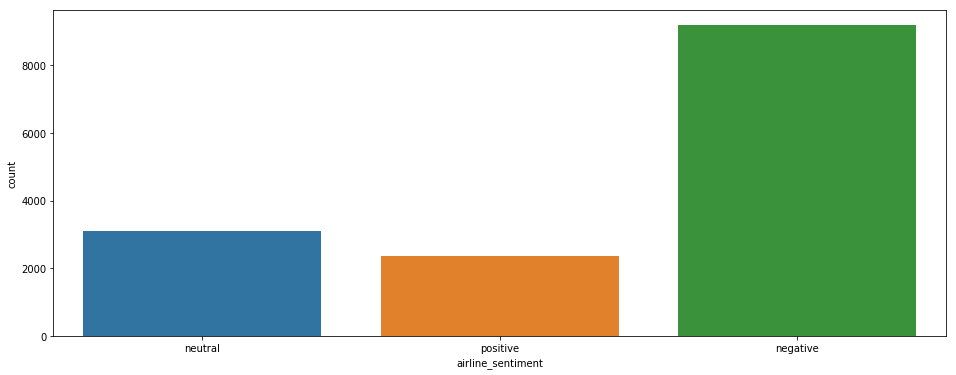

In [11]:
plt.figure(figsize=(16,6))
sns.countplot(x='airline_sentiment', data=df)

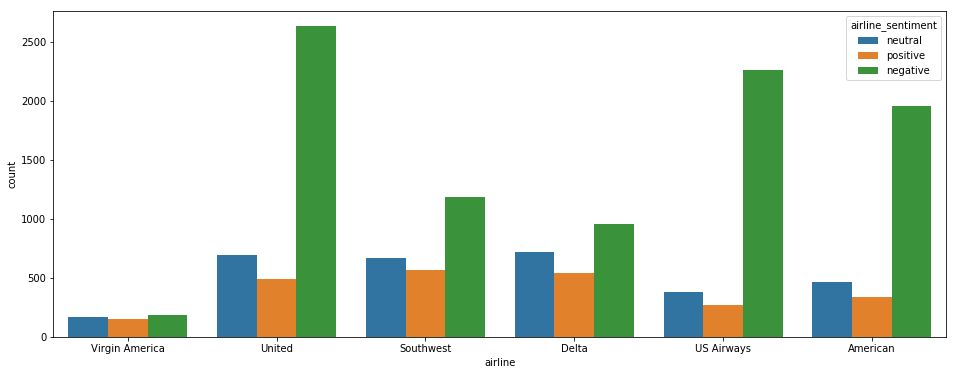

In [12]:
plt.figure(figsize=(16,6))
sns.countplot(x='airline', data=df, hue='airline_sentiment')

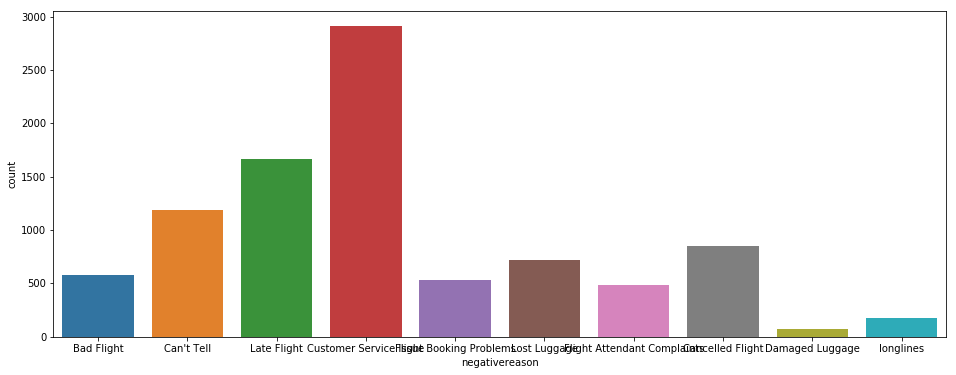

In [13]:
plt.figure(figsize=(16,6))
sns.countplot(x='negativereason', data=df)

In [14]:
min(df['tweet_created'])

'2015-02-16 23:36:05 -0800'

In [15]:
max(df['tweet_created'])

'2015-02-24 11:53:37 -0800'

## Format data for language model training

These steps separate out just the tweets and the labels into a csv file, then load this data into a Text List databunch, using 90% for training and 10% for validation. The language model ignores the labels, these will be used later for the classifier. On loading into a databunch, the data is tokenized and numericalized.

In [0]:
newdf = df[['airline_sentiment','text']].copy()

In [0]:
newdf.columns = ['label','text']

In [0]:
newdf.to_csv('Tweets1.csv')

In [19]:
shutil.copyfile('Tweets1.csv', './gdrive/My Drive/Colab Notebooks/data/Tweets1.csv')

'./gdrive/My Drive/Colab Notebooks/data/Tweets1.csv'

In [0]:
newdf = pd.read_csv('./gdrive/My Drive/Colab Notebooks/data/Tweets1.csv')

In [21]:
newdf.head()

,Unnamed: 0,label,text
0,0,neutral,@VirginAmerica What @dhepburn said.
1,1,positive,@VirginAmerica plus you've added commercials t...
2,2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,3,negative,@VirginAmerica it's really aggressive to blast...
4,4,negative,@VirginAmerica and it's a really big bad thing...


In [0]:
path = './gdrive/My Drive/Colab Notebooks/data/'

In [0]:
bs=48

In [0]:
data_lm = (TextList.from_csv(path, 'Tweets1.csv', cols='text')
           #Inputs: all the text files in path
            .split_subsets(train_size=0.9, valid_size=0.1)
           #We randomly split and keep 10% (10,000 reviews) for validation
            .label_for_lm()           
           #We want to do a language model so we label accordingly
            .databunch(bs=bs))
data_lm.save('data_lm.pkl')

In [0]:
data_lm = load_data(path, 'data_lm.pkl', bs=bs)

In [26]:
data_lm.show_batch()

idx,text
0,"no it is n't - xxunk incompetence was xxunk at xxup dfw today . i was there . xxmaj on a plane on the xxup xxunk runway . i doubt you were . xxbos @united some compensation ( xxunk upgrade to higher class for my rescheduled flight to xxup xxunk today ) will be appreciated , though ;) xxbos @jetblue i will try that . xxmaj thanks ! xxmaj if"
1,"are n't medical equipment and that she should have "" planned better . "" xxbos @jetblue where is the "" award winning service "" ? xxbos @southwestair now it 's delayed until xxunk . xxmaj getting yelled at by attendants not to bother them . xxmaj getting worse xxbos @americanair no vouchers 4 xxmaj cancelled xxmaj flighted flight due 2 weather . xxmaj today 's issue , broken tire ."
2,"xxbos @united well if you do n't want your customers to be frustrated compensate them xxunk when you screw up xxunk ! ! # xxunk xxbos @southwestair xxmaj thank you ! xxbos @jetblue xxmaj is there something going on with your alerts ? xxmaj flight 's been delayed several times for my parents and i 'm not receiving any alerts . xxbos @united not just refunded , but for those"
3,"a concern , i 'll just travel with someone else moving forward . xxbos @americanair they responded . i ca n't respond to their response . xxmaj nor can i speak with someone . # worstcustomerserviceever xxbos @usairways i have run out of patience .. xxmaj we are sitting in a bus without air in front of plane and there is no communication from xxunk xxbos @united of xxunk ,"
4,are xxunk on plane . xxbos @southwestair xxmaj so i guess you can get to the airport too early ! xxmaj need to wait xxunk to checkin . xxmaj really ? xxbos @southwestair xxmaj no like i said i could not reach anyone at your company so i had to rent a car and xxunk the whole thing up to a loss xxbos @jetblue xxup ta off site at #


In [27]:
data_lm.vocab.itos[:10]

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep',
 '.']

In [28]:
data_lm.train_ds[0][0]

Text xxbos @jetblue xxmaj airways xxmaj short xxmaj interest xxmaj down 3.5 % in xxmaj january ( xxup jblu ) - xxunk http : / / t.co / xxunk

In [29]:
data_lm.train_ds[0][0].data[:10]

array([   2,   32,    5,  434,    5,  965,    5, 2367,    5,  314])

## Train language model

The langauge model is the AWD_LSTM model (https://arxiv.org/pdf/1708.02182.pdf) pretrained on wikitext-103 (https://blog.einstein.ai/the-wikitext-long-term-dependency-language-modeling-dataset/).

Here we find the probable best learning rates using fastai's lr_find (rule of thumb is choose a learning rate where the loss is decreasing, a bit before it starts to increase again).

Then train initially for one cycle, then unfreeze all weights, find best probable learning rate and train for 5 epochs. 

In early testing that I did, training for 10 epochs here resulted in overtraining, indicating that this probably would do better with a larger dataset.


In [0]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

In [31]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


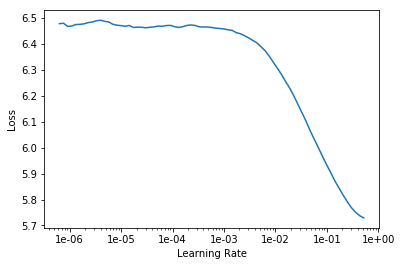

In [32]:
learn.recorder.plot(skip_end=15)

In [33]:
learn.fit_one_cycle(1, 1e-1, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.329069,3.940457,0.261093,00:28


In [0]:
learn.save('fit_head')

In [0]:
learn.load('fit_head');

In [0]:
learn.unfreeze()

In [37]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


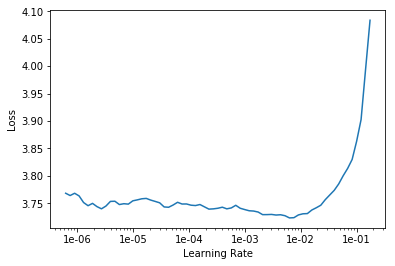

In [38]:
learn.recorder.plot(skip_end=15)

In [39]:
learn.fit_one_cycle(5, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.687370,3.819306,0.276894,00:35
1,3.529029,3.725609,0.289394,00:35
2,3.271562,3.720577,0.290801,00:35
3,3.008260,3.772441,0.289637,00:35
4,2.783135,3.828104,0.287689,00:35


In [0]:
learn.save('fine_tuned')

In [0]:
learn.load('fine_tuned');

## Evaluate language model

The model reached 28.77% for predicting the next word, which is about as expected for a dataset like this (similar to IMDb example by fastai of ~30%).

To test if the model can create sensible output, I test it here on the first phrases: "I had a good flight" and "I had a bad flight", which should in theory produce positive and negative outputs.

The resulting otuputs are tweet-like, and there you can see some positive words in the first set of examples and some negative words in the second set of examples, but they really are a bit mixed up. But they show that the language model is probably sufficient for these purposes.

In [0]:
TEXT = "I had a good flight"
N_WORDS = 40
N_SENTENCES = 5

In [43]:
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

I had a good flight , and so rebooked too . But not my bag . Flight was Cancelled Flightled . Can you help ? xxbos @usairways ca n't change my flight . i have been on hold for 1.5
I had a good flight , but did n't get a meal voucher . My family was first here , but i have been here all day . xxbos @jetblue i was not sure i can change my flight . Luckily i was
I had a good flight , but it went it directed someone to the next day . xxbos @usairways awesome flight attendant today who was rude and unwilling to help . Awesome ! ! xxbos @usairways i 'm trying to change my flight tomorrow
I had a good flight Our flight scheduled to depart at DFW ! Thanks for the great service ! xxbos @southwestair - Anything you can do for me on this flight ? xxbos @southwestair Great job today . Also
I had a good flight of the morning and got it off her seat . She was very helpful and helpful . She was amazing ! ! xxbos @united Thanks JB - Nassau News Live http : /


In [0]:
TEXT = "I had a bad flight"
N_WORDS = 40
N_SENTENCES = 5

In [45]:
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

I had a bad flight , but i was told by an agent that she was " able to sleep " on a ticket . By the way , she would be able to help xxbos @united i would like to send a letter
I had a bad flight experience and stuck on the runway in Phoenix because the engine is broken . 
  # americanairlines xxbos @southwestair Found my seat and you lost my baggage . Got ta be happy xxbos @southwestair No ,
I had a bad flight - but stuck in the middle of the night . Just got off . xxbos @united You lost my bags . # Memphis xxbos @jetblue Is there any way to get another flight in a few
I had a bad flight and not my first time flying with you ! Thanks for the help ! xxbos @usairways i love you guys ! You guys are so impressed with me . xxbos @americanair we are on a flight for tomorrow
I had a bad flight , but now i 'm stuck on an tarmac in Cleveland because of your shitty delays . xxbos @americanair and it is n't possible to have a voucher for a hotel . i just want to call to speak


In [0]:
learn.save_encoder('fine_tuned_enc')

## Train classifier

The classifier uses the encoder part of the langauge model and the labels from the dataset.

Here the classifier is trained with progressively more layers included in training.

In [0]:
data_clas = (TextList.from_csv(path, 'Tweets1.csv', cols='text', vocab=data_lm.vocab)
             #grab all the text files in path
             .split_subsets(train_size=0.9, valid_size=0.1)
             #split to 0.9 training and 0.1 validation
             .label_from_df(cols=1, classes=['negative','neutral','positive'])
             #label them all with their folders
             .databunch(bs=bs))

data_clas.save('data_clas.pkl')

In [0]:
data_clas = load_data(path, 'data_clas.pkl', bs=bs)

In [49]:
data_clas.show_batch()

text,target
xxbos @united xxmaj hi have a question re future xxmaj flight xxmaj booking xxmaj problems . xxup xxunk - xxup xxunk 29 / 9 xxup xxunk - xxup lax 8 / 10 xxup lax - xxup xxunk 13 / 10 . i 'm * xxup xxunk xxmaj what is checked bag xxunk for xxup xxunk - xxup lax ?,neutral
xxbos @southwestair xxmaj the xxmaj fact xxmaj that u xxmaj see xxmaj black xxmaj history xxmaj month 12 xxmaj months a xxmaj year xxmaj is xxmaj xxunk ! xxmaj we xxup will xxup be xxmaj an xxmaj xxunk xxmaj xxunk xxmaj for xxmaj xxunk xxmaj like u xxmaj in xxmaj future !,positive
"xxbos @united xxmaj hi , i m flying xxup sfo - xxup lax - xxup xxunk - xxup xxunk . xxmaj my connecting time in xxup lax is xxunk m . xxmaj is it enough time ? xxmaj do i have to collect my bag and xxunk on xxup xxunk ?",neutral
"xxbos @usairways e xxrep 4 y ! xxmaj cancelled xxmaj flightlations , xxmaj flight xxmaj booking xxmaj problemss , reflight xxmaj booking xxmaj problemss , but y' all got me on the same flight out tonight ( not tomorrow ) & & the xxup fc upgrade . xxmaj thx !",positive
xxbos @virginamerica xxmaj many xxmaj thanks for the xxmaj follow . \n # xxunk # xxunk # xxup usa # xxmaj xxunk \n xxmaj looking for xxmaj any xxmaj help 😍 \n 💗 🇬 🇧 💗 🇺 🇸 💗 \n 🎀 xxunk 🎀 http : / / t.co / xxunk,neutral


In [0]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn.load_encoder('fine_tuned_enc');

In [51]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


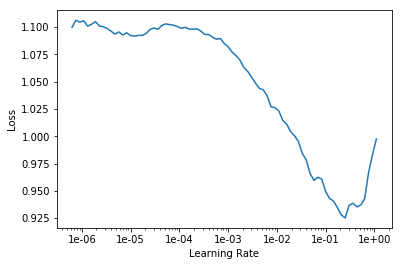

In [52]:
learn.recorder.plot()

In [53]:
learn.fit_one_cycle(1, 2e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.670388,0.516347,0.794399,00:16


In [0]:
learn.save('first')

In [0]:
learn.load('first');

In [56]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.595649,0.464893,0.821038,00:19


In [0]:
learn.save('second')

In [0]:
learn.load('second');

In [59]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.557994,0.437373,0.830601,00:33


In [0]:
learn.save('third')

In [0]:
learn.load('third');

In [62]:
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.479976,0.430617,0.834016,00:43
1,0.440693,0.427157,0.838115,00:42


In [0]:
learn.save('fourth')

In [0]:
learn.load('fourth');

## Evaluate classifier

From above, the accuracy on the validation set was 83.81%

The classifier predicts the following simple sentences correctly:


In [65]:
learn.predict("I had a terrible flight")

(Category negative, tensor(0), tensor([0.6827, 0.0438, 0.2735]))

In [66]:
learn.predict("I had a great flight")

(Category positive, tensor(2), tensor([0.0072, 0.0046, 0.9882]))

In [67]:
learn.predict("I had an average flight")

(Category neutral, tensor(1), tensor([0.3723, 0.4346, 0.1931]))

## Conclusions

The language model reached an accuracy of 28.77% for predicting the next word.

The classifier reached an accuracy of 83.81% for predicting the sentiment of the tweet.

This could be improved by increasing the size of the dataset, working out better ways to clean the tweets in the dataset (grammatical errors, typos, hashtags), or possibly by using the sentiment confidence in some way (as those with lower than 1.0 confidence have been classified by people into different categories).